In [1]:
import random
from typing import Callable, Optional, TypedDict

import numpy as np
import polars as pl
from obp.dataset import SyntheticBanditDataset
from obp.ope import BaseOffPolicyEstimator, InverseProbabilityWeighting, ReplayMethod

/Users/masato.morita/Library/Caches/pypoetry/virtualenvs/recommender-experiments-_FVBVT8O-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BanditFeedbackDict(TypedDict):
    n_rounds: int  # ラウンド数
    n_actions: int  # アクション数s
    context: np.ndarray  # 文脈 (shape: (n_rounds, dim_context))
    action_context: np.ndarray  # アクション特徴量 (shape: (n_actions, dim_action_features))
    action: np.ndarray  # 実際に選択されたアクション (shape: (n_rounds,))
    position: Optional[np.ndarray]  # ポジション (shape: (n_rounds,) or None)
    reward: np.ndarray  # 報酬 (shape: (n_rounds,))
    expected_reward: np.ndarray  # 期待報酬 (shape: (n_rounds, n_actions))
    pi_b: np.ndarray  # データ収集方策 P(a|x) (shape: (n_rounds, n_actions))
    pscore: np.ndarray  # 傾向スコア (shape: (n_rounds,))

In [3]:
# 真の期待報酬関数 E_{p(r|x,a)}[r] を定義する
def expected_reward_function(
    context: np.ndarray,  # shape: (n_rounds, dim_context)
    action_context: np.ndarray,  # shape: (n_actions, dim_action_context)
    random_state: int = None,
) -> np.ndarray:  # (n_rounds, n_actions, len_list)
    """(アクションa, 文脈x)の各組み合わせに対する期待報酬 E_{p(r|x,a)}[r] を定義する関数
    返り値のshape: (n_rounds, n_actions, len_list)
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 固定の期待報酬を設定 (今回は報酬rをbinary変数とするので0.0~1.0の連続値を設定)
    fixed_scores = np.array([i for i in range(n_actions)])
    fixed_rewards = fixed_scores / n_actions

    # 文脈の数だけ期待報酬を繰り返して返す
    return np.tile(fixed_rewards, (n_rounds, 1))


# 試しに期待報酬関数を実行してみる
n_rounds = 3
n_actions = 50
dim_context = 300
dim_action_context = 300
context = np.random.random((n_rounds, dim_context))
action_context = np.random.random((n_actions, dim_action_context))
print(expected_reward_function(context, action_context))

[[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
  0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
  0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
  0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98]
 [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
  0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
  0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
  0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98]
 [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
  0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
  0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
  0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98]]


In [4]:
# 5種類の推薦方策を定義していく


from typing import Literal


def pi_1(context: np.ndarray, action_context: np.ndarray, random_state: int = None) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_1$ を確率1で推薦する決定的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.zeros(n_actions)
    p_scores[1] = 1.0
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_2(context: np.ndarray, action_context: np.ndarray, random_state: int = None) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_1$ と $a_2$ を確率0.5で推薦する確率的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.zeros(n_actions)
    p_scores[1:3] = 0.5
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_3(context: np.ndarray, action_context: np.ndarray, random_state: int = None) -> np.ndarray:
    """コンテキスト考慮なしの確率的方策(epsilon-greedy)
    - epsilon=0.1とする。
    - 活用フェーズでは、必ず最後尾のニュース $a_{|A|-1}$ を選択する。
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 確率的方策: 確率0.1で全てのアクションを一様ランダムに選択し、確率0.9で最後尾のアクションを選択
    epsilon = 0.1
    action_dist = np.full((n_rounds, n_actions), epsilon / n_actions)
    last_action_idx = n_actions - 1
    action_dist[np.arange(n_rounds), last_action_idx] = 1.0 - epsilon + epsilon / n_actions

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_4(context: np.ndarray, action_context: np.ndarray, random_state: int = None) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も大きいニュースを
    確率1で推薦する決定的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmax(scores, axis=1)  # shape: (n_rounds,)

    # 決定的方策: 確率1で最もスコアが高いアクションを選択
    action_dist = np.zeros((n_rounds, n_actions))
    action_dist[np.arange(n_rounds), selected_actions] = 1.0

    return action_dist


def pi_5(context: np.ndarray, action_context: np.ndarray, random_state: int = None) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も大きいニュースを
    確率0.7で推薦し、その他のニュースを均等に確率0.1で推薦する確率的方策。
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmax(scores, axis=1)  # shape: (n_rounds,)

    # 確率的方策: 確率0.1で全てのアクションを一様ランダムに選択し、確率0.6で最もスコアが高いアクションを決定的に選択
    epsilon = 0.1
    action_dist = np.full((n_rounds, n_actions), epsilon / n_actions)
    action_dist[np.arange(n_rounds), selected_actions] = 1.0 - epsilon + epsilon / n_actions
    return action_dist


n_rounds = 3
dim_context = 300
n_actions = 10
print(
    pi_4(context=np.random.random((n_rounds, dim_context)), action_context=np.random.random((n_actions, dim_context)))
)
print(
    pi_5(context=np.random.random((n_rounds, dim_context)), action_context=np.random.random((n_actions, dim_context)))
)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.91 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.91 0.01 0.01 0.01 0.01]]


In [5]:
def policy_wrapper(
    base_policy: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    mode: Literal["logging_poicy", "target_policy_name"],
) -> Callable[[np.ndarray, np.ndarray, int], np.ndarray]:
    """
    方策のラッパー関数。データ収集時と評価時で出力の形状を切り替える。
    (logging_policyの場合はshape=(n_rounds, n_actions)、target_policyの場合はshape=(n_rounds,n_actions, 1))
    Parameters
    - base_policy: ベースとなる方策関数
    - mode: 方策のモード。"logging_policy"はデータ収集方策、"target_policy"は評価方策

    Returns
    - wrapされた方策関数
    """

    def wrapped_policy(context: np.ndarray, action_context: np.ndarray, random_state: int = None) -> np.ndarray:
        action_dist = base_policy(context, action_context, random_state)
        if mode == "logging_policy":
            return action_dist
        elif mode == "target_policy":
            return action_dist[:, :, np.newaxis]

    return wrapped_policy


target_policy_name = policy_wrapper(pi_5, mode="target_policy")
print(target_policy_name(context=np.array([[1], [2], [3]]), action_context=np.array([[1], [2], [3], [4]])))

[[[0.025]
  [0.025]
  [0.025]
  [0.925]]

 [[0.025]
  [0.025]
  [0.025]
  [0.925]]

 [[0.025]
  [0.025]
  [0.025]
  [0.925]]]


In [6]:
def run_single_ope_simulation(
    simulate_idx: int,
    n_rounds: int,
    n_actions: int,
    dim_context: int,
    action_context: np.ndarray,
    reward_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    logging_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    target_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
) -> dict:
    # データ収集方策によって集められるはずの、擬似バンディットデータの設定を定義
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_function,
        behavior_policy_function=logging_policy_function,
        random_state=simulate_idx,
        action_context=action_context,
    )
    # 収集されるバンディットフィードバックデータを生成
    bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

    # bandit_feedbackをpl.DataFrameに変換
    selected_action_contexts = action_context[bandit_feedback["action"], :]
    bandit_feedback_df = pl.DataFrame(
        {
            "time_step": [i for i in range(n_rounds)],
            "context": bandit_feedback["context"].tolist(),
            "action": bandit_feedback["action"].tolist(),
            "action_context": selected_action_contexts.tolist(),
            "reward": bandit_feedback["reward"].tolist(),
            "p_score": bandit_feedback["pscore"].tolist(),
        }
    )

    # 評価方策を使って、ログデータ(bandit_feedback)に対する行動選択確率を計算
    target_policy_action_dist = target_policy_function(
        context=bandit_feedback["context"], action_context=bandit_feedback["action_context"]
    )
    # 真の期待報酬E_{p(r|x,a)}[r]を使って、データ収集方策の代わりに評価方策を動かした場合の性能を計算
    ground_truth_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback["expected_reward"], action_dist=target_policy_action_dist
    )

    # OPE推定量を準備(naive推定量とIPS推定量)
    naive_estimator = ReplayMethod()
    ips_estimator = InverseProbabilityWeighting()

    # それぞれのOPE推定量を使って、データ収集方策の代わりに評価方策を動かした場合の価値を推定
    estimated_policy_value_by_naive = naive_estimator.estimate_policy_value(
        reward=bandit_feedback["reward"], action=bandit_feedback["action"], action_dist=target_policy_action_dist
    )
    estimated_policy_value_by_ips = ips_estimator.estimate_policy_value(
        action=bandit_feedback["action"],
        reward=bandit_feedback["reward"],
        action_dist=target_policy_action_dist,
        pscore=bandit_feedback["pscore"],
    )

    return {
        "simulate_idx": simulate_idx,
        "ground_truth_policy_value": ground_truth_policy_value,
        "naive_estimate": estimated_policy_value_by_naive,
        "naive_error": ground_truth_policy_value - estimated_policy_value_by_naive,
        "ips_estimate": estimated_policy_value_by_ips,
        "ips_error": ground_truth_policy_value - estimated_policy_value_by_ips,
    }


# シミュレーションの設定
simulate_idx = 0
n_rounds = 20000
n_actions = 50
dim_context = 300
action_context = np.random.random((n_actions, dim_context))
reward_function = expected_reward_function
logging_policy_function = policy_wrapper(pi_3, mode="logging_policy")
target_policy_function = policy_wrapper(pi_4, mode="target_policy")

# シミュレーションを実行
result_dict = run_single_ope_simulation(
    simulate_idx=simulate_idx,
    n_rounds=n_rounds,
    n_actions=n_actions,
    dim_context=dim_context,
    action_context=action_context,
    reward_function=reward_function,
    logging_policy_function=logging_policy_function,
    target_policy_function=target_policy_function,
)
print(result_dict)

{'simulate_idx': 0, 'ground_truth_policy_value': 0.485292, 'naive_estimate': 0.9233038348082596, 'naive_error': -0.4380118348082596, 'ips_estimate': 0.31668514412416854, 'ips_error': 0.16860685587583146}


In [7]:
from pandera.polars import DataFrameSchema
from pandera.typing.polars import DataFrame


class SimulationResult(DataFrameSchema):
    logging_policy_name: str
    n_rounds: int
    target_policy_true_value: float
    naive_estimate: float
    naive_error: float
    ips_estimate: float
    ips_error: float


# 5つの推薦方策をデータ収集方策として、ある一つの評価方策に対してOPEを実行する
def pi_6(context: np.ndarray, action_context: np.ndarray, random_state: int = None) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も小さいニュースを
    確率1で推薦する決定的方策 (pi_4とは逆の方策)
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmin(scores, axis=1)  # shape: (n_rounds,)

    # 決定的方策: 確率1で最もスコアが高いアクションを選択
    action_dist = np.zeros((n_rounds, n_actions))
    action_dist[np.arange(n_rounds), selected_actions] = 1.0

    return action_dist


# シミュレーションの設定
def run_multiple_simulations(
    logging_policy_map: dict[str, Callable[[np.ndarray, np.ndarray, int], np.ndarray]],
    target_policy: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    n_rounds_list: list[int] = [50, 100, 200, 300, 400, 500, 1000, 10000],
    n_actions: int = 50,
    dim_context: int = 300,
    action_context: np.ndarray = np.random.random((n_actions, dim_context)),
) -> DataFrame[SimulationResult]:
    results = []
    for logging_policy_name in logging_policy_map.keys():
        for n_rounds in n_rounds_list:
            result_dict = run_single_ope_simulation(
                simulate_idx=0,
                n_rounds=n_rounds,
                n_actions=n_actions,
                dim_context=dim_context,
                action_context=action_context,
                reward_function=expected_reward_function,
                logging_policy_function=policy_wrapper(logging_policy_map[logging_policy_name], mode="logging_policy"),
                target_policy_function=policy_wrapper(target_policy, mode="target_policy"),
            )
            results.append(
                {
                    "logging_policy_name": logging_policy_name,
                    "n_rounds": n_rounds,
                    "target_policy_true_value": result_dict["ground_truth_policy_value"],
                    "naive_estimate": result_dict["naive_estimate"],
                    "naive_error": result_dict["naive_error"],
                    "ips_estimate": result_dict["ips_estimate"],
                    "ips_error": result_dict["ips_error"],
                }
            )
    return pl.DataFrame(results)


policy_map = {"pi_1": pi_1, "pi_2": pi_2, "pi_3": pi_3, "pi_4": pi_4, "pi_5": pi_5}
result_df = run_multiple_simulations(policy_map, pi_6, n_rounds_list=list(range(1000, 20000, 1000)))
print(result_df)

shape: (95, 7)
┌───────────────┬──────────┬───────────────┬──────────────┬─────────────┬──────────────┬───────────┐
│ logging_polic ┆ n_rounds ┆ target_policy ┆ naive_estima ┆ naive_error ┆ ips_estimate ┆ ips_error │
│ y_name        ┆ ---      ┆ _true_value   ┆ te           ┆ ---         ┆ ---          ┆ ---       │
│ ---           ┆ i64      ┆ ---           ┆ ---          ┆ f64         ┆ f64          ┆ f64       │
│ str           ┆          ┆ f64           ┆ f64          ┆             ┆              ┆           │
╞═══════════════╪══════════╪═══════════════╪══════════════╪═════════════╪══════════════╪═══════════╡
│ pi_1          ┆ 1000     ┆ 0.5072        ┆ 0.0          ┆ 0.5072      ┆ 0.0          ┆ 0.5072    │
│ pi_1          ┆ 2000     ┆ 0.50286       ┆ 0.0          ┆ 0.50286     ┆ 0.0          ┆ 0.50286   │
│ pi_1          ┆ 3000     ┆ 0.505233      ┆ 0.0          ┆ 0.505233    ┆ 0.0          ┆ 0.505233  │
│ pi_1          ┆ 4000     ┆ 0.501545      ┆ 0.0          ┆ 0.501545    ┆ 0.

In [8]:
# 小数点以下4桁までに丸める
rounded_opl_result_df = result_df.with_columns(
    [
        result_df["naive_estimate"].round(4).alias("naive_estimate"),
        result_df["naive_error"].round(4).alias("naive_error"),
        result_df["ips_estimate"].round(4).alias("ips_estimate"),
        result_df["ips_error"].round(4).alias("ips_error"),
    ]
)
display(rounded_opl_result_df)

# 結果をcsvファイルに保存
rounded_opl_result_df.write_csv("result.csv")

logging_policy_name,n_rounds,target_policy_true_value,naive_estimate,naive_error,ips_estimate,ips_error
str,i64,f64,f64,f64,f64,f64
"""pi_1""",1000,0.5072,0.0,0.5072,0.0,0.5072
"""pi_1""",2000,0.50286,0.0,0.5029,0.0,0.5029
"""pi_1""",3000,0.505233,0.0,0.5052,0.0,0.5052
"""pi_1""",4000,0.501545,0.0,0.5015,0.0,0.5015
"""pi_1""",5000,0.50148,0.0192,0.4822,0.0002,0.5013
…,…,…,…,…,…,…
"""pi_5""",15000,0.499248,0.4667,0.0326,0.7,-0.2008
"""pi_5""",16000,0.498633,0.4468,0.0518,0.6563,-0.1576
"""pi_5""",17000,0.499424,0.4375,0.0619,0.6176,-0.1182


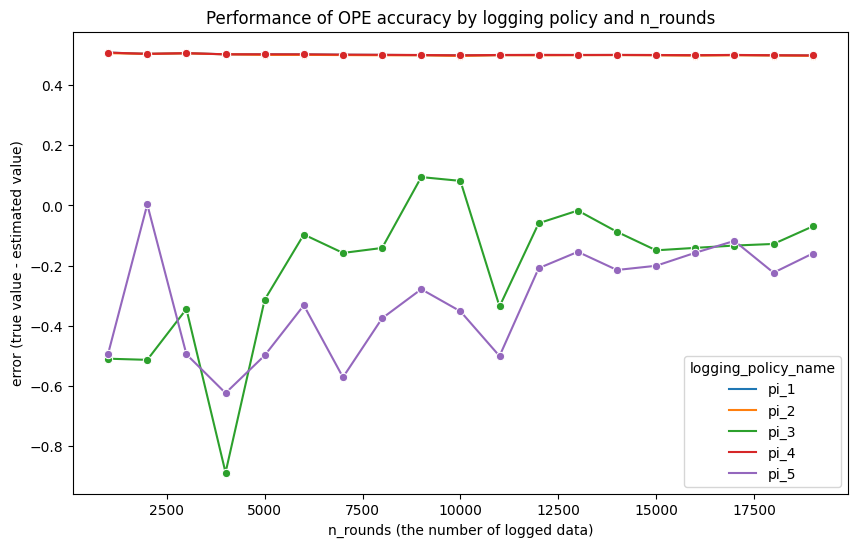

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 横軸 n_rounds, 縦軸 真の性能 のグラフを描画
# グラフの描画
plt.figure(figsize=(10, 6))
sns.lineplot(data=rounded_opl_result_df.to_pandas(), x="n_rounds", y="ips_error", hue="logging_policy_name", marker="o")
# plt.xscale("log")
plt.xlabel("n_rounds (the number of logged data)")
plt.ylabel("error (true value - estimated value)")
plt.title("Performance of OPE accuracy by logging policy and n_rounds")
plt.legend(title="logging_policy_name")
plt.show()

In [17]:
# オフライン学習のシミュレーション
from obp.policy import BernoulliTS, IPWLearner, LogisticTS, NNPolicyLearner, Random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from recommender_experiments.service.opl.two_tower_nn_model import TwoTowerNNPolicyLearner


def run_single_opl_simulation(
    simulate_idx: int,
    n_rounds: int,
    n_actions: int,
    dim_context: int,
    action_context: np.ndarray,
    reward_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    logging_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    hyperparams: dict = {"base_model": {"max_iter": 1000}},
) -> dict:
    # データ収集方策によって集められるはずの、擬似バンディットデータの設定を定義
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_function,
        behavior_policy_function=logging_policy_function,
        random_state=simulate_idx,
        action_context=action_context,
    )
    # 学習用とテスト用のデータセットを生成
    bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=10000)
    bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)
    new_policy = IPWLearner(n_actions=n_actions, base_classifier=LogisticRegression(**hyperparams["base_model"]))

    new_policy.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    nn_policy_learner = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dim_context,
        off_policy_objective="ipw",
        hidden_layer_size=(100,),
        activation="relu",
        solver="adam",
    )
    # nn_policy_learner.fit(
    #     context=bandit_feedback_train["context"],
    #     action=bandit_feedback_train["action"],
    #     reward=bandit_feedback_train["reward"],
    #     pscore=bandit_feedback_train["pscore"],
    # )

    # 自作のtwo-tower NNを使った方策学習
    two_tower_nn_policy_learner = TwoTowerNNPolicyLearner(
        dim_context=dim_context,
        dim_action_features=bandit_feedback_train["action_context"].shape[1],
        dim_two_tower_embedding=10,
    )
    two_tower_nn_policy_learner.fit(
        context=bandit_feedback_train["context"],
        action_context=bandit_feedback_train["action_context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # オフライン学習した方策を使って、テストデータに対する性能を評価
    ## 各評価方策をテスト用データセットに適用した時のアクション選択確率を算出
    test_action_dist = new_policy.predict(context=bandit_feedback_test["context"])
    ## # 真の即時報酬の期待値を使って、各方策の真の累積報酬の期待値を算出
    ground_truth_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"], action_dist=test_action_dist
    )

    # NNPolicyの方も同様に評価
    test_action_dist_nn = nn_policy_learner.predict_proba(context=bandit_feedback_test["context"])
    ground_truth_policy_value_nn = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"], action_dist=test_action_dist_nn
    )
    print(f"{ground_truth_policy_value_nn=}")

    # 自前のTwoTowerNNPolicyLearnerの方も同様に評価
    test_action_dist_two_tower_nn = two_tower_nn_policy_learner.predict_proba(
        context=bandit_feedback_test["context"], action_context=bandit_feedback_test["action_context"]
    )
    ground_truth_policy_value_two_tower_nn = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"], action_dist=test_action_dist_two_tower_nn
    )
    print(f"{ground_truth_policy_value_two_tower_nn=}")

    # ちなみに、これで学習した新方策のパラメータを取得できる(保存などもできる)
    models = new_policy.base_classifier_list
    print(models)  # 長さ=len_listのlist[sklearn.linear_model.LogisticRegression]が返ってくる
    model = models[0]
    print(type(model))

    return {"simulate_idx": simulate_idx, "n_rounds": n_rounds, "ground_truth_policy_value": ground_truth_policy_value}


# シミュレーションの設定
simulate_idx = 1
n_rounds = 10000
n_actions = 50
dim_context = 3
action_context = np.random.random((n_actions, dim_context))
reward_function = expected_reward_function
logging_policy_function = policy_wrapper(pi_3, mode="logging_policy")


# 1回のシミュレーションを実行
result_dict = run_single_opl_simulation(
    simulate_idx=simulate_idx,
    n_rounds=n_rounds,
    n_actions=n_actions,
    dim_context=dim_context,
    action_context=action_context,
    reward_function=reward_function,
    logging_policy_function=logging_policy_function,
)
print(result_dict)

overriden __post_init__ for TwoTower Model
Context Tower - Layer 0: 3 -> 100
Action Tower - Layer 0: 3 -> 100
overriden fit method


policy learning:   1%|          | 2/200 [00:00<00:32,  6.10it/s]

0th epoch: loss_value=2.3853790760040283
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
1th epoch: loss_value=1.9531490802764893
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   2%|▏         | 4/200 [00:00<00:27,  7.21it/s]

2th epoch: loss_value=2.6588358879089355
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
3th epoch: loss_value=2.301645517349243
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   3%|▎         | 6/200 [00:00<00:26,  7.24it/s]

4th epoch: loss_value=1.8470650911331177
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
5th epoch: loss_value=2.0248987674713135
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   4%|▍         | 8/200 [00:01<00:22,  8.39it/s]

6th epoch: loss_value=2.2310924530029297
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
7th epoch: loss_value=2.272660732269287
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   5%|▌         | 10/200 [00:01<00:23,  7.94it/s]

8th epoch: loss_value=2.302025556564331
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
9th epoch: loss_value=1.7148005962371826
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   6%|▌         | 12/200 [00:01<00:25,  7.24it/s]

10th epoch: loss_value=1.9506601095199585
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
11th epoch: loss_value=1.8820054531097412
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   7%|▋         | 14/200 [00:01<00:24,  7.47it/s]

12th epoch: loss_value=2.34429669380188
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
13th epoch: loss_value=2.227616548538208
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   8%|▊         | 16/200 [00:02<00:24,  7.63it/s]

14th epoch: loss_value=2.198038101196289
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
15th epoch: loss_value=2.237863779067993
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:   9%|▉         | 18/200 [00:02<00:23,  7.78it/s]

16th epoch: loss_value=1.83688485622406
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
17th epoch: loss_value=1.9948840141296387
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  10%|█         | 20/200 [00:02<00:22,  7.85it/s]

18th epoch: loss_value=1.716338872909546
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
19th epoch: loss_value=1.8442631959915161
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  11%|█         | 22/200 [00:02<00:22,  7.85it/s]

20th epoch: loss_value=1.5791208744049072
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
21th epoch: loss_value=1.8784897327423096
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  12%|█▏        | 24/200 [00:03<00:22,  7.86it/s]

22th epoch: loss_value=1.9984214305877686
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
23th epoch: loss_value=2.157714366912842
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  13%|█▎        | 26/200 [00:03<00:23,  7.32it/s]

24th epoch: loss_value=1.9987330436706543
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
25th epoch: loss_value=1.645615816116333
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  14%|█▍        | 28/200 [00:03<00:23,  7.25it/s]

26th epoch: loss_value=2.075453996658325
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
27th epoch: loss_value=2.1939094066619873
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  15%|█▌        | 30/200 [00:04<00:23,  7.25it/s]

28th epoch: loss_value=2.23700213432312
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
29th epoch: loss_value=1.6829578876495361
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  16%|█▌        | 32/200 [00:04<00:22,  7.31it/s]

30th epoch: loss_value=2.601593494415283
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
31th epoch: loss_value=1.7525852918624878
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  17%|█▋        | 34/200 [00:04<00:22,  7.29it/s]

32th epoch: loss_value=2.1176459789276123
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
33th epoch: loss_value=2.232517719268799
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  18%|█▊        | 36/200 [00:04<00:22,  7.30it/s]

34th epoch: loss_value=2.345752477645874
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
35th epoch: loss_value=2.100468635559082
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  19%|█▉        | 38/200 [00:05<00:22,  7.32it/s]

36th epoch: loss_value=1.9182910919189453
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
37th epoch: loss_value=2.0755813121795654
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  20%|██        | 40/200 [00:05<00:23,  6.90it/s]

38th epoch: loss_value=1.9846059083938599
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
39th epoch: loss_value=1.7521357536315918
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  21%|██        | 42/200 [00:05<00:22,  7.09it/s]

40th epoch: loss_value=2.00076961517334
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
41th epoch: loss_value=2.2302968502044678
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  22%|██▏       | 44/200 [00:05<00:21,  7.16it/s]

42th epoch: loss_value=1.9212127923965454
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
43th epoch: loss_value=1.7204045057296753
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  23%|██▎       | 46/200 [00:06<00:21,  7.15it/s]

44th epoch: loss_value=1.730591058731079
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
45th epoch: loss_value=1.842820405960083
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  24%|██▍       | 48/200 [00:06<00:18,  8.12it/s]

46th epoch: loss_value=1.965152621269226
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
47th epoch: loss_value=1.600048542022705
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  25%|██▌       | 50/200 [00:06<00:18,  7.98it/s]

48th epoch: loss_value=2.111586332321167
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
49th epoch: loss_value=2.2408313751220703
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  26%|██▌       | 52/200 [00:07<00:20,  7.21it/s]

50th epoch: loss_value=1.799452304840088
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
51th epoch: loss_value=2.411090612411499
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  27%|██▋       | 54/200 [00:07<00:19,  7.54it/s]

52th epoch: loss_value=2.0299911499023438
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
53th epoch: loss_value=1.9218461513519287
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  28%|██▊       | 56/200 [00:07<00:18,  7.70it/s]

54th epoch: loss_value=1.9177770614624023
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
55th epoch: loss_value=2.1185085773468018
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  29%|██▉       | 58/200 [00:07<00:18,  7.83it/s]

56th epoch: loss_value=1.8681281805038452
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
57th epoch: loss_value=2.287172555923462
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  30%|███       | 60/200 [00:08<00:17,  7.83it/s]

58th epoch: loss_value=2.332479476928711
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
59th epoch: loss_value=1.9921088218688965
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  31%|███       | 62/200 [00:08<00:17,  7.88it/s]

60th epoch: loss_value=1.7544498443603516
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
61th epoch: loss_value=1.8025437593460083
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  32%|███▏      | 64/200 [00:08<00:19,  6.99it/s]

62th epoch: loss_value=1.7490897178649902
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
63th epoch: loss_value=1.9946410655975342
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  33%|███▎      | 66/200 [00:08<00:21,  6.36it/s]

64th epoch: loss_value=2.0326967239379883
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
65th epoch: loss_value=2.0029795169830322
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  34%|███▍      | 68/200 [00:09<00:21,  6.28it/s]

66th epoch: loss_value=1.4183247089385986
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
67th epoch: loss_value=2.362247943878174
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  35%|███▌      | 70/200 [00:09<00:19,  6.54it/s]

68th epoch: loss_value=2.1494691371917725
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
69th epoch: loss_value=2.5820512771606445
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  36%|███▌      | 72/200 [00:09<00:19,  6.71it/s]

70th epoch: loss_value=1.8096612691879272
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
71th epoch: loss_value=2.317371129989624
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  36%|███▋      | 73/200 [00:10<00:17,  7.29it/s]

72th epoch: loss_value=1.9131642580032349
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  38%|███▊      | 75/200 [00:10<00:18,  6.73it/s]

73th epoch: loss_value=2.4777145385742188
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
74th epoch: loss_value=2.543781280517578
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  38%|███▊      | 77/200 [00:10<00:17,  7.14it/s]

75th epoch: loss_value=1.9276775121688843
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
76th epoch: loss_value=2.373286247253418
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  40%|███▉      | 79/200 [00:10<00:16,  7.38it/s]

77th epoch: loss_value=1.8011581897735596
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
78th epoch: loss_value=1.5292625427246094
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  40%|████      | 81/200 [00:11<00:17,  6.66it/s]

79th epoch: loss_value=1.928694248199463
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
80th epoch: loss_value=1.9205387830734253
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  42%|████▏     | 83/200 [00:11<00:16,  7.17it/s]

81th epoch: loss_value=1.8352575302124023
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
82th epoch: loss_value=2.2790722846984863
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  42%|████▎     | 85/200 [00:11<00:15,  7.51it/s]

83th epoch: loss_value=2.3575806617736816
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
84th epoch: loss_value=2.700284004211426
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  44%|████▎     | 87/200 [00:12<00:14,  7.54it/s]

85th epoch: loss_value=2.2391459941864014
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
86th epoch: loss_value=2.191833257675171
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  44%|████▍     | 89/200 [00:12<00:15,  7.04it/s]

87th epoch: loss_value=2.277409553527832
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
88th epoch: loss_value=1.9119079113006592
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  46%|████▌     | 91/200 [00:12<00:15,  7.12it/s]

89th epoch: loss_value=1.7652479410171509
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
90th epoch: loss_value=1.7959699630737305
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  46%|████▋     | 93/200 [00:12<00:16,  6.65it/s]

91th epoch: loss_value=1.5041155815124512
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
92th epoch: loss_value=1.8946224451065063
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  48%|████▊     | 95/200 [00:13<00:14,  7.02it/s]

93th epoch: loss_value=2.278273105621338
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
94th epoch: loss_value=1.8169231414794922
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  48%|████▊     | 97/200 [00:13<00:14,  7.11it/s]

95th epoch: loss_value=2.4330170154571533
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
96th epoch: loss_value=1.7746328115463257
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  50%|████▉     | 99/200 [00:13<00:14,  7.13it/s]

97th epoch: loss_value=2.1559314727783203
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
98th epoch: loss_value=2.11616849899292
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  50%|█████     | 101/200 [00:13<00:13,  7.17it/s]

99th epoch: loss_value=1.6181917190551758
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
100th epoch: loss_value=2.163455009460449
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  52%|█████▏    | 103/200 [00:14<00:14,  6.75it/s]

101th epoch: loss_value=1.897588849067688
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
102th epoch: loss_value=2.386162281036377
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  52%|█████▎    | 105/200 [00:14<00:13,  6.94it/s]

103th epoch: loss_value=2.482041120529175
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
104th epoch: loss_value=2.0455057621002197
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  54%|█████▎    | 107/200 [00:14<00:13,  7.05it/s]

105th epoch: loss_value=1.8424214124679565
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
106th epoch: loss_value=2.005441427230835
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  55%|█████▍    | 109/200 [00:15<00:12,  7.09it/s]

107th epoch: loss_value=1.9108891487121582
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
108th epoch: loss_value=1.7439403533935547
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  56%|█████▌    | 111/200 [00:15<00:10,  8.16it/s]

109th epoch: loss_value=2.416792631149292
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
110th epoch: loss_value=2.0547304153442383
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  56%|█████▋    | 113/200 [00:15<00:11,  7.65it/s]

111th epoch: loss_value=2.185032367706299
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
112th epoch: loss_value=2.177778959274292
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  57%|█████▊    | 115/200 [00:15<00:10,  7.75it/s]

113th epoch: loss_value=2.120008707046509
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
114th epoch: loss_value=1.8399919271469116
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  58%|█████▊    | 117/200 [00:16<00:10,  7.76it/s]

115th epoch: loss_value=2.2459511756896973
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
116th epoch: loss_value=1.3386297225952148
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  60%|█████▉    | 119/200 [00:16<00:10,  7.87it/s]

117th epoch: loss_value=2.074281930923462
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
118th epoch: loss_value=2.2750046253204346
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  60%|██████    | 121/200 [00:16<00:09,  7.93it/s]

119th epoch: loss_value=2.163402557373047
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
120th epoch: loss_value=2.5209226608276367
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  62%|██████▏   | 123/200 [00:16<00:10,  7.42it/s]

121th epoch: loss_value=1.8825823068618774
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
122th epoch: loss_value=1.9560779333114624
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  62%|██████▎   | 125/200 [00:17<00:09,  7.52it/s]

123th epoch: loss_value=2.12600040435791
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
124th epoch: loss_value=1.7686290740966797
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  64%|██████▎   | 127/200 [00:17<00:09,  7.61it/s]

125th epoch: loss_value=2.1601343154907227
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
126th epoch: loss_value=2.1508076190948486
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  64%|██████▍   | 129/200 [00:17<00:09,  7.57it/s]

127th epoch: loss_value=2.1152398586273193
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
128th epoch: loss_value=2.344372034072876
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  66%|██████▌   | 131/200 [00:18<00:09,  7.21it/s]

129th epoch: loss_value=1.7381348609924316
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
130th epoch: loss_value=1.9256640672683716
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  66%|██████▋   | 133/200 [00:18<00:09,  7.10it/s]

131th epoch: loss_value=2.208089828491211
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
132th epoch: loss_value=1.6868658065795898
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  68%|██████▊   | 135/200 [00:18<00:09,  7.08it/s]

133th epoch: loss_value=2.633988380432129
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
134th epoch: loss_value=1.972591757774353
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  68%|██████▊   | 137/200 [00:18<00:08,  7.06it/s]

135th epoch: loss_value=2.272268533706665
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
136th epoch: loss_value=1.7754565477371216
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  70%|██████▉   | 139/200 [00:19<00:08,  7.12it/s]

137th epoch: loss_value=1.9154248237609863
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
138th epoch: loss_value=2.230893135070801
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  70%|███████   | 141/200 [00:19<00:08,  7.20it/s]

139th epoch: loss_value=2.168771505355835
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
140th epoch: loss_value=1.6887425184249878
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  72%|███████▏  | 143/200 [00:19<00:08,  6.84it/s]

141th epoch: loss_value=1.9465124607086182
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
142th epoch: loss_value=2.1853418350219727
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  72%|███████▎  | 145/200 [00:20<00:07,  7.01it/s]

143th epoch: loss_value=2.0107526779174805
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
144th epoch: loss_value=1.8903729915618896
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  74%|███████▎  | 147/200 [00:20<00:07,  7.14it/s]

145th epoch: loss_value=2.272653579711914
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
146th epoch: loss_value=2.0780115127563477
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  74%|███████▍  | 149/200 [00:20<00:07,  7.27it/s]

147th epoch: loss_value=2.3983519077301025
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
148th epoch: loss_value=2.201523542404175
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  76%|███████▌  | 151/200 [00:20<00:07,  6.87it/s]

149th epoch: loss_value=1.6579079627990723
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
150th epoch: loss_value=2.0776243209838867
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  76%|███████▋  | 153/200 [00:21<00:05,  7.97it/s]

151th epoch: loss_value=2.356353998184204
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
152th epoch: loss_value=2.14910888671875
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  78%|███████▊  | 155/200 [00:21<00:05,  7.96it/s]

153th epoch: loss_value=2.1185050010681152
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
154th epoch: loss_value=1.616917371749878
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  78%|███████▊  | 157/200 [00:21<00:05,  7.87it/s]

155th epoch: loss_value=1.950334906578064
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
156th epoch: loss_value=2.2021052837371826
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  80%|███████▉  | 159/200 [00:21<00:05,  7.68it/s]

157th epoch: loss_value=2.0206339359283447
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
158th epoch: loss_value=2.1324892044067383
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  80%|████████  | 161/200 [00:22<00:05,  7.71it/s]

159th epoch: loss_value=2.005390167236328
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
160th epoch: loss_value=2.1284945011138916
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  82%|████████▏ | 163/200 [00:22<00:05,  7.34it/s]

161th epoch: loss_value=2.046543598175049
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
162th epoch: loss_value=2.343132972717285
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  82%|████████▎ | 165/200 [00:22<00:04,  7.56it/s]

163th epoch: loss_value=2.123770236968994
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
164th epoch: loss_value=2.3443851470947266
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  84%|████████▎ | 167/200 [00:22<00:04,  7.54it/s]

165th epoch: loss_value=1.773208498954773
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
166th epoch: loss_value=1.9681384563446045
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  84%|████████▍ | 169/200 [00:23<00:04,  7.62it/s]

167th epoch: loss_value=2.20228910446167
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
168th epoch: loss_value=2.001262664794922
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  86%|████████▌ | 171/200 [00:23<00:03,  7.67it/s]

169th epoch: loss_value=2.0285208225250244
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
170th epoch: loss_value=2.152771234512329
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  86%|████████▋ | 173/200 [00:23<00:03,  7.73it/s]

171th epoch: loss_value=1.9239579439163208
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
172th epoch: loss_value=2.537649154663086
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  88%|████████▊ | 175/200 [00:24<00:03,  7.29it/s]

173th epoch: loss_value=1.6357547044754028
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
174th epoch: loss_value=2.010009527206421
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  88%|████████▊ | 177/200 [00:24<00:03,  6.90it/s]

175th epoch: loss_value=1.8369321823120117
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
176th epoch: loss_value=1.9243978261947632
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  90%|████████▉ | 179/200 [00:24<00:02,  7.03it/s]

177th epoch: loss_value=2.300778865814209
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
178th epoch: loss_value=2.071087598800659
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  90%|█████████ | 181/200 [00:24<00:02,  7.10it/s]

179th epoch: loss_value=1.8992654085159302
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
180th epoch: loss_value=2.083374261856079
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  92%|█████████▏| 183/200 [00:25<00:02,  7.14it/s]

181th epoch: loss_value=2.3118209838867188
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
182th epoch: loss_value=1.9510507583618164
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  92%|█████████▎| 185/200 [00:25<00:02,  7.15it/s]

183th epoch: loss_value=1.8074018955230713
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
184th epoch: loss_value=1.8688963651657104
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  94%|█████████▎| 187/200 [00:25<00:01,  7.12it/s]

185th epoch: loss_value=2.435626983642578
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
186th epoch: loss_value=1.5953619480133057
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  94%|█████████▍| 189/200 [00:25<00:01,  6.81it/s]

187th epoch: loss_value=2.2015328407287598
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
188th epoch: loss_value=1.8818492889404297
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  96%|█████████▌| 191/200 [00:26<00:01,  7.00it/s]

189th epoch: loss_value=2.6177446842193604
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
190th epoch: loss_value=1.7860199213027954
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  96%|█████████▋| 193/200 [00:26<00:00,  7.09it/s]

191th epoch: loss_value=1.8408381938934326
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
192th epoch: loss_value=2.1352808475494385
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  98%|█████████▊| 195/200 [00:26<00:00,  8.03it/s]

193th epoch: loss_value=1.6212143898010254
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
194th epoch: loss_value=2.0257320404052734
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning:  98%|█████████▊| 197/200 [00:27<00:00,  7.87it/s]

195th epoch: loss_value=1.8073492050170898
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
196th epoch: loss_value=2.3495235443115234
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning: 100%|█████████▉| 199/200 [00:27<00:00,  7.81it/s]

197th epoch: loss_value=2.1596431732177734
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
198th epoch: loss_value=2.0643703937530518
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True


policy learning: 100%|██████████| 200/200 [00:27<00:00,  7.29it/s]


199th epoch: loss_value=2.3604190349578857
policy_grad_arr.requires_grad: True
policy_constraint.requires_grad: True
ground_truth_policy_value_nn=0.5004697213970852
ground_truth_policy_value_two_tower_nn=0.4938714440138003
[LogisticRegression(max_iter=1000)]
<class 'sklearn.linear_model._logistic.LogisticRegression'>
{'simulate_idx': 1, 'n_rounds': 10000, 'ground_truth_policy_value': 0.7933960000000001}


In [49]:
import itertools

from loguru import logger
from pandera.polars import DataFrameSchema
from pandera.typing.polars import DataFrame


class SimulationResult(DataFrameSchema):
    logging_policy_name: str
    n_rounds: int
    trained_policy_true_value: float


# 5つの推薦方策について、データ収集方策と評価方策の組み合わせを作って、シミュレーションを実行する


# シミュレーションの設定
def run_multiple_simulations(
    policy_map: dict[str, Callable[[np.ndarray, np.ndarray, int], np.ndarray]],
    n_rounds_list: list[int] = [50, 100, 200, 300, 400, 500, 1000, 10000],
    n_actions: int = 4,
    dim_context: int = 3,
    action_context: np.ndarray = np.random.random((n_actions, dim_context)),
) -> DataFrame[SimulationResult]:
    results = []
    for logging_policy_name in policy_map.keys():
        for n_rounds in n_rounds_list:
            logger.info(f"simulation: {logging_policy_name=}, {n_rounds=}")
            # データ収集方策と評価方策を指定して、シミュレーションを実行
            result_dict = run_single_opl_simulation(
                simulate_idx=0,
                n_rounds=n_rounds,
                n_actions=n_actions,
                dim_context=dim_context,
                action_context=action_context,
                reward_function=expected_reward_function,
                logging_policy_function=policy_wrapper(policy_map[logging_policy_name], mode="logging_policy"),
            )
            results.append(
                {
                    "logging_policy_name": logging_policy_name,
                    "n_rounds": n_rounds,
                    "trained_policy_true_value": result_dict["ground_truth_policy_value"],
                }
            )
    return pl.DataFrame(results)


logging_policy_map = {
    # "pi_1": pi_1, # 一種類しか正解ラベルがないとエラーになってしまうのでコメントアウト
    "pi_2": pi_2,
    "pi_3": pi_3,
    "pi_4": pi_4,
    "pi_5": pi_5,
}
result_df = run_multiple_simulations(
    logging_policy_map,
    n_rounds_list=list(range(1000, 50000, 1000)),
    n_actions=4,
    dim_context=20,
    action_context=np.random.random((4, 20)),
)

rounded_opl_result_df = result_df.with_columns(result_df["trained_policy_true_value"].round(3))
print(rounded_opl_result_df)

rounded_opl_result_df.write_csv("result_opl.csv")

2024-12-24 17:29:51.718 | INFO     | __main__:run_multiple_simulations:28 - simulation: logging_policy_name='pi_2', n_rounds=1000
2024-12-24 17:29:51.752 | INFO     | __main__:run_multiple_simulations:28 - simulation: logging_policy_name='pi_2', n_rounds=2000
2024-12-24 17:29:51.772 | INFO     | __main__:run_multiple_simulations:28 - simulation: logging_policy_name='pi_2', n_rounds=3000
2024-12-24 17:29:51.791 | INFO     | __main__:run_multiple_simulations:28 - simulation: logging_policy_name='pi_2', n_rounds=4000
2024-12-24 17:29:51.803 | INFO     | __main__:run_multiple_simulations:28 - simulation: logging_policy_name='pi_2', n_rounds=5000
2024-12-24 17:29:51.835 | INFO     | __main__:run_multiple_simulations:28 - simulation: logging_policy_name='pi_2', n_rounds=6000
2024-12-24 17:29:51.852 | INFO     | __main__:run_multiple_simulations:28 - simulation: logging_policy_name='pi_2', n_rounds=7000
2024-12-24 17:29:51.870 | INFO     | __main__:run_multiple_simulations:28 - simulation: lo

shape: (196, 3)
┌─────────────────────┬──────────┬───────────────────────────┐
│ logging_policy_name ┆ n_rounds ┆ trained_policy_true_value │
│ ---                 ┆ ---      ┆ ---                       │
│ str                 ┆ i64      ┆ f64                       │
╞═════════════════════╪══════════╪═══════════════════════════╡
│ pi_2                ┆ 1000     ┆ 0.496                     │
│ pi_2                ┆ 2000     ┆ 0.492                     │
│ pi_2                ┆ 3000     ┆ 0.5                       │
│ pi_2                ┆ 4000     ┆ 0.499                     │
│ pi_2                ┆ 5000     ┆ 0.5                       │
│ …                   ┆ …        ┆ …                         │
│ pi_5                ┆ 45000    ┆ 0.737                     │
│ pi_5                ┆ 46000    ┆ 0.746                     │
│ pi_5                ┆ 47000    ┆ 0.736                     │
│ pi_5                ┆ 48000    ┆ 0.738                     │
│ pi_5                ┆ 49000    ┆ 0.74

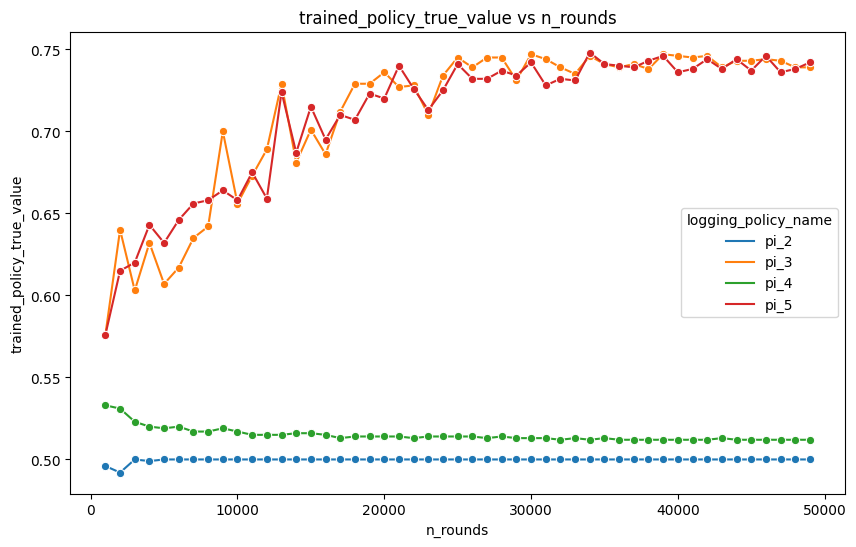

In [50]:
import seaborn as sns

# 横軸 n_rounds, 縦軸 真の性能 のグラフを描画
# グラフの描画
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=rounded_opl_result_df.to_pandas(),
    x="n_rounds",
    y="trained_policy_true_value",
    hue="logging_policy_name",
    marker="o",
)
# plt.xscale("log")
plt.xlabel("n_rounds")
plt.ylabel("trained_policy_true_value")
plt.title("trained_policy_true_value vs n_rounds")
plt.legend(title="logging_policy_name")
plt.show()